#  Song Lyric Analysis and Pre-processing

In this notebook, we will perform exploratory data analysis on our song lyric dataset. We will also process our lyric text using various tools from the NLTK library. All data cleaning and pre-processing steps are also in the `preprocess.py` script.

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [53]:
data = pd.read_csv("data/lyrics.csv")
print("Number of songs: {:d}".format(data.shape[0]))

Number of songs: 362237


## Step 1: Exploratory Data Analysis

In [54]:
data.head(1)

,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."


#### Missing Values

In [55]:
data.isnull().sum()

index         0
song          2
year          0
artist        0
genre         0
lyrics    95680
dtype: int64

There are 95680 songs that have missing lyrics. Let's drop all rows with missing values.

In [56]:
data = data.dropna()
print("Number of songs after dropping missing values:", data.shape[0])

Number of songs after dropping missing values: 266556


Let's also remove any artist-song duplicates.

In [57]:
data = data.drop_duplicates(subset=['artist', 'song'])
print("Number of songs after dropping duplicates:", data.shape[0])

Number of songs after dropping duplicates: 266060


In [58]:
print("There were {:d} duplicates that were removed.".format(266556-266060))

There were 496 duplicates that were removed.


### Which genre is the most popular?

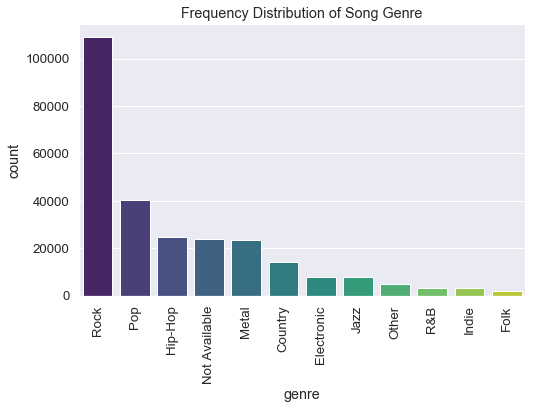

In [59]:
genres = data['genre'].value_counts().reset_index()
genres.columns = ['genre', 'count']

sns.set_style("whitegrid")
sns.set(font_scale=1.2)
plt.figure(figsize=(8,5))
sns.barplot(x='genre', y='count', data=genres, palette='viridis')
plt.xticks(rotation=90)
plt.title('Frequency Distribution of Song Genre')
plt.show()

In [60]:
print("The most popular genre is {:s}, followed by {:s}.".format(genres['genre'][0], genres['genre'][1]))
print("The least popular genre is {:s}.".format(genres["genre"].iloc[-1]))

The most popular genre is Rock, followed by Pop.
The least popular genre is Folk.


### Which artist has the most songs?

Mean number of songs per artist: 18.29.
Median number of songs per artist: 4.00.


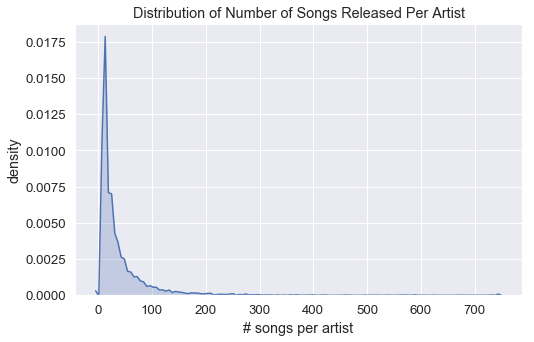

In [61]:
artists = data['artist'].value_counts().reset_index()
artists.columns = ['artist', 'count']

print("Mean number of songs per artist: {:.2f}.".format(artists['count'].mean()))
print("Median number of songs per artist: {:.2f}.".format(artists['count'].median()))

plt.figure(figsize=(8,5))
sns.kdeplot(artists['count'], shade=True, legend=False)
plt.xlabel('# songs per artist')
plt.ylabel('density')
plt.title('Distribution of Number of Songs Released Per Artist')
plt.show()

In [62]:
print("The artist with the most songs in this dataset is {:s}.".format(artists['artist'][0]))

The artist with the most songs in this dataset is dolly-parton.


### When are songs most frequently released?

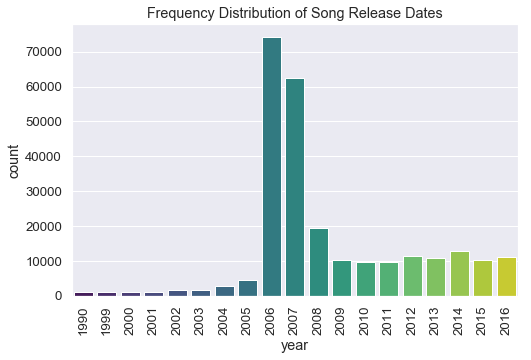

In [63]:
years = data['year'].value_counts().reset_index()
years.columns = ['year', 'count']

# filter out years that have count less than 1000
years = years[years['count'] > 1000]

plt.figure(figsize=(8,5))
sns.barplot(x='year', y='count', data=years, palette='viridis')
plt.xticks(rotation=90)
plt.title("Frequency Distribution of Song Release Dates")
plt.show()

This dataset has the most songs released in 2006.

## Step 2: Pre-processing Song Lyrics

To keep our data a manageable size, let’s focus on all lyrics by Bob Dylan. We need to subset our dataframe accordingly.

In [81]:
subset = data[data['artist'] == 'bob-dylan']

There are 590 songs by Bob Dylan.

#### Tokenizing words

Our lyrics need to be tokenized in order to properly analyze their content. Tokenization is the process of breaking up a string into smaller pieces. In this particular example, we will be breaking up a song's lyrics into a string of words. We will also remove stopwords using NLTK's stopwords library, and words that have less than 3 characters. 

In [82]:
def tokenize_lyrics(x, min_length=3):
    custom_stopwords = ["'s", "n't", "'m", "'re", "'ll","'ve","...", "ä±", "''", '``','--', "'d", 'el', 'la', "let"]
    stopwords = nltk.corpus.stopwords.words('english') + custom_stopwords
    tokens = nltk.word_tokenize(x.lower())
    tokens = [t.strip('-./') for t in tokens]
    tokenized = [t for t in tokens if len(t) > min_length and t.isalpha() and t not in stopwords]
    return tokenized

In [100]:
subset['tokenized_lyrics'] = subset['lyrics'].apply(tokenize_lyrics)
subset['word_count'] = subset['tokenized_lyrics'].apply(len)
subset = subset[subset['word_count'] > 10]

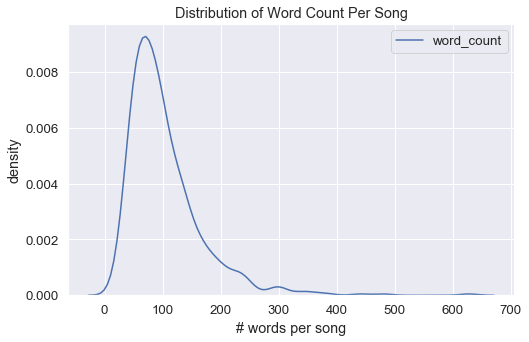

In [101]:
# filter out songs that have more than 1000 words
subset_filtered = subset[subset['word_count'] < 1000]

plt.figure(figsize=(8,5))
sns.kdeplot(subset_filtered['word_count'])
plt.xlabel("# words per song")
plt.ylabel("density")
plt.title("Distribution of Word Count Per Song")
plt.show()

In [110]:
print("Mean number of words:", round(subset['word_count'].mean(), 2))
print("Median number of words:", subset['word_count'].median())
longest_song = subset['word_count'].max()
print("Song with highest word count:", subset[subset['word_count']==longest_song]['song'][201578])
shortest_song = subset['word_count'].min()
print("Song with lowest word count:", subset[subset['word_count']==shortest_song]['song'][201546])

Mean number of words: 104.2
Median number of words: 88.5
Song with highest word count: last-thoughts-on-woody-guthrie
Song with lowest word count: sally-gal


#### Stemming and Lemmatization

After tokenizing the lyrics and filtering out stopwords, our next step is to perform stemming and/or lemmatization. These two techniques work by grouping inflected words to a common base form. For example, `organize`, `organizes`, and `organizing` are different forms of the same meaning and could be grouped into the same category. 
Stemming is a crude process that simply chops off ends of words in attempt to identify a word's root. Lemmatization is a more complex technique that performs a morphological analysis on words in attempt to identify its "lemma" (or proper root).

In this particular example, we will be using lemmatization to group our inflected words. We will use NLTK's `WordNetLemmatizer` class.

In [88]:
from nltk.stem import WordNetLemmatizer

def lemmatize(tokens):
    tokens = [WordNetLemmatizer().lemmatize(t) for t in tokens]
    return tokens

subset['tokenized_lyrics'] = subset['tokenized_lyrics'].apply(lemmatize)

Now that we have our tokenized and lemmatized/stemmed lyrics, let's see which words are most common in our `Bob Dylan` lyric dataset.

In [89]:
from collections import Counter

word_freq = Counter(w for words in subset['tokenized_lyrics'] for w in words)
print("Top 10 most common words are:", word_freq.most_common(10))

Top 10 most common words are: [('well', 755), ('like', 717), ('know', 686), ('come', 607), ('love', 540), ('time', 479), ('said', 439), ('babi', 376), ('want', 375), ('could', 326)]


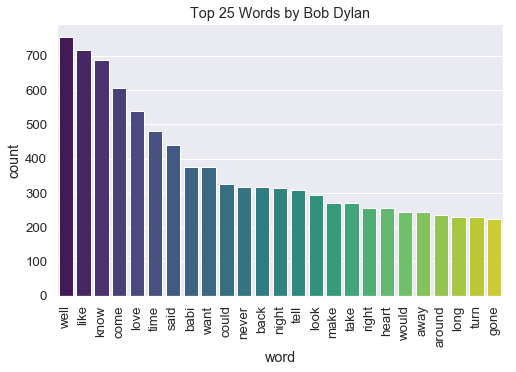

In [90]:
top_n = 25
common_words = pd.DataFrame(word_freq.most_common(top_n), columns=['word', 'count'])

plt.figure(figsize=(8,5))
sns.barplot(x='word', y='count', data=common_words, palette="viridis")
plt.title("Top {:d} Words by Bob Dylan".format(top_n))
plt.xticks(rotation=90)
plt.show()